# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at mlta-2023-spring@googlegroups.com



## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [1]:
!pip install -q swig
!pip install box2d==2.3.2 gym[box2d]==0.25.2 box2d-py pyvirtualdisplay tqdm numpy==1.22.4 
!pip install box2d==2.3.2 box2d-kengz
!pip freeze > requirements.txt


Next, set up virtual display，and import all necessaary packages.

In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [3]:
seed = 2023 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [4]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment". 

In this homework, we will utilize the function `step()` to control the action of "Agent". 

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [5]:
print(env.observation_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [6]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment. 
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [7]:
initial_state = env.reset()
print(initial_state)

[-0.00506535  1.413064   -0.5130838   0.09527162  0.00587628  0.11622101
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [8]:
random_action = env.action_space.sample()
print(random_action)

1


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [9]:
observation, reward, done, info = env.step(random_action)

In [10]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. 

In [11]:
print(reward)

-1.4981841929643156


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

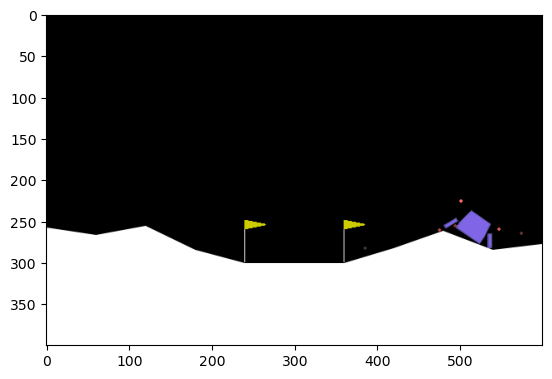

In [12]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## DQN

In [13]:
# reference : https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
class DQN(nn.Module):

    def __init__(self, n_observations=8, n_actions=4):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities. 

In [14]:
# reference : https://github.com/ranjitation/DQN-for-LunarLander, https://github.com/udacity/deep-reinforcement-learning
from collections import namedtuple, deque
import random

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class DQNAgent():
    """Interacts with and learns from the environment."""
    def __init__(self, network, num_states, num_actions, memory_capacity = 10000, GAMMA = 0.99):
        """Initialize an Agent object."""
        
        self.num_states = num_states
        self.num_actions = num_actions
        self.gamma = GAMMA
        
        # Replay memory
        self.memory = ReplayMemory(memory_capacity)
        
        # Q-Network
        self.main_q_network = network
        self.target_q_network = network
        
        # optimizer
        self.optimizer = optim.RMSprop(self.main_q_network.parameters(), lr=1e-4)
    
    def update_q_function(self):
        '''update q function'''
        
        # no enough samples, just return
        if len(self.memory) < BATCH_SIZE:
            return
        # If enough samples are available in memory, get random subset and learn
        self.batch, self.state_batch, self.action_batch, self.reward_batch, self.non_final_next_states = self.make_minibatch()
        
        self.expected_state_action_values = self.get_expected_state_action_values()

        self.update_main_q_network()

    def make_minibatch(self):
        '''Creating a mini-batch'''

        transitions = self.memory.sample(BATCH_SIZE)

        Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
        batch = Transition(*zip(*transitions))


        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        return batch, state_batch, action_batch, reward_batch, non_final_next_states

    def get_expected_state_action_values(self):
        '''calculate Q（St,at）'''

        self.main_q_network.eval()
        self.target_q_network.eval()

        self.state_action_values = self.main_q_network(
            self.state_batch).gather(1, self.action_batch)

        non_final_mask = torch.BoolTensor(tuple(map(lambda s: s is not None,
                                                    self.batch.next_state)))
        # set all state to 0
        next_state_values = torch.zeros(BATCH_SIZE)

        next_state_values[non_final_mask] = self.target_q_network(
            self.non_final_next_states).max(1)[0].detach()
        # DQN formula
        expected_state_action_values = self.reward_batch + self.gamma * next_state_values
        
        return expected_state_action_values
        
    def get_action(self, state, episode, test=False):
        """Returns actions for given state as per current policy."""
        if test:
            self.main_q_network.eval()
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.main_q_network(torch.from_numpy(state).unsqueeze(0)).max(1)[1].view(1, 1)
            return action.item()
        
        global steps_done

        # epsilon = 0.5 * (1 / (episode + 1))
        epsilon = EPS_END + (EPS_START - EPS_END) * \
                np.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
        
        if epsilon <= np.random.uniform(0, 1):
            #print('use max')
            self.main_q_network.eval()
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.main_q_network(state).max(1)[1].view(1, 1)
        else:
            #print('random')
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  
            
        return action

    def update_main_q_network(self):
        
        '''update main q net'''

        # set train mode
        self.main_q_network.train()
        # Hurberloss function
        # expected_state_action_values (minbatch,)->(minbatchx1)

        loss = F.smooth_l1_loss(self.state_action_values,
                                self.expected_state_action_values.unsqueeze(1))

        # update
        self.optimizer.zero_grad()  # reset gradient
        loss.backward()  # backpropagation
        for param in self.main_q_network.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()  # update network

    # def sample(self, state):
    #     """Randomly sample a batch of experiences from memory."""
    #     experiences = random.sample(self.memory, k=self.batch_size)

    #     states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    #     actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
    #     rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
    #     next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
    #     dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
    #     return (states, actions, rewards, next_states, dones)
    
    def memorize(self, state, action, state_next, reward):
        '''save state, action, state_next, reward into replay memory'''
        self.memory.push(state, action, state_next, reward)

    def update_target_q_function(self):
        
        '''synchronize Target Q-Network to Main Q-Network'''
        self.target_q_network.load_state_dict(self.main_q_network.state_dict())

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Lastly, build a network and agent to start training.

In [15]:
network = DQN()
agent = DQNAgent(network, env.observation_space.shape[0], env.action_space.n)

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [16]:
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 600        # 總共更新 400 次
BATCH_SIZE = 32
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

best_score = 0
best_batch = 0

steps_done = 0
agent.main_q_network.train()
agent.target_q_network.train()
avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    rewards = []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        observation = env.reset() # 環境的初始化
        state = observation  # 將觀測結果直接當成狀態s使用
        state = torch.from_numpy(state).type(torch.FloatTensor)  # 將NumPy變數轉換成PyTorch的張量
        state = torch.unsqueeze(state, 0)  # 將size 4轉換成size 1x4
        total_reward, total_step = 0, 0

        while True:

            action = agent.get_action(state, batch)  # 求出動作，執行動作a_t後，算出s_{t+1}與done旗標
            # 根據action指定.item()、再取得內容
            observation_next, reward, done, _ = env.step(action.item())  # 不會用到info，所以設定為_

            total_reward += reward
            total_step += 1
            rewards.append(reward) #改這裡
            # ! 重要 ！
            # 現在的reward 的implementation 為每個時刻的瞬時reward, 給定action_list : a1, a2, a3 ......
            #                                                       reward :     r1, r2 ,r3 ......
            # medium：將reward調整成accumulative decaying reward, 給定action_list : a1,                         a2,                           a3 ......
            #                                                       reward :     r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement DQN
            if done:
                state_next = None  # 沒有下個狀態，所以存入None

            else:
                state_next = observation_next  # 直接將觀測結果當成狀態使用
                state_next = torch.from_numpy(state_next).type(torch.FloatTensor)  # 將numpy變數轉換成PyTorch的張量
                state_next = torch.unsqueeze(state_next, 0)  # 將size 4轉換成size 1x4
                
            # 將學習經驗存入記憶體
            agent.memorize(state, action, state_next, torch.FloatTensor([reward]))
            
            # 以Experience Replay更新Q函數
            agent.update_q_function()
            
            # 觀測狀態的更新
            state = state_next
            
            # 結束時的處理
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break
                

    #print(f"rewards looks like ", np.shape(rewards))      
    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    # rewards = np.concatenate(rewards, axis=0)
    #rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.update_target_q_function()
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(np.array(rewards)).size())


    ### testing
    fix(env, seed)
    agent.main_q_network.eval()
    NUM_OF_TEST = 5 # Do not revise it !!!!!
    test_total_reward = []
    action_list = []
    for i in range(NUM_OF_TEST):
        actions = []
        state = env.reset()

        #img = plt.imshow(env.render(mode='rgb_array'))

        total_reward = 0

        done = False
        while not done:
            action = agent.get_action(state, episode=i, test=True)
            actions.append(action)
            state, reward, done, _ = env.step(action)

            total_reward += reward

        print(total_reward)
        test_total_reward.append(total_reward)

        action_list.append(actions)
        print("length of actions is ", len(actions))
    print(f"Your final reward is : %.2f"%np.mean(test_total_reward))
    if np.mean(test_total_reward) > 275:
        distribution = {}
        for actions in action_list:
            for action in actions:
                if action not in distribution.keys():
                    distribution[action] = 1
                else:
                    distribution[action] += 1
        PATH = "Action_List_test" + str(batch) + ".npy"
        np.save(PATH ,np.array(action_list)) 
        if np.mean(test_total_reward) > best_score:
            best_score = np.mean(test_total_reward)
            best_batch = batch
            print('Improve to score %.2f at batch %d'% (best_score, best_batch ))

  0%|          | 0/600 [00:00<?, ?it/s]

torch.from_numpy(rewards) looks like  torch.Size([433])
-364.8440478399337
length of actions is  80
-352.61450687295417
length of actions is  72
-436.50139743877656
length of actions is  98
-432.43380061037084
length of actions is  76
-431.9862399100542
length of actions is  84
Your final reward is : -403.68
torch.from_numpy(rewards) looks like  torch.Size([803])
-619.353480921762
length of actions is  76
-610.9605698094158
length of actions is  81
-442.8328471212226
length of actions is  83
-521.3564847361547
length of actions is  85
-479.16660645038166
length of actions is  91
Your final reward is : -534.73
torch.from_numpy(rewards) looks like  torch.Size([438])
-201.06749579743544
length of actions is  1000
-227.67459470565674
length of actions is  1000
-222.26570443058293
length of actions is  1000
-146.0212068407952
length of actions is  1000
-149.38362711059514
length of actions is  1000
Your final reward is : -189.28
torch.from_numpy(rewards) looks like  torch.Size([2039])
-198.

/tmp/ipykernel_205840/1581037806.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(PATH ,np.array(action_list))


Improve to score 277.09 at batch 186
torch.from_numpy(rewards) looks like  torch.Size([1281])
43.68495378244066
length of actions is  143
57.14731175393919
length of actions is  139
36.2256226107169
length of actions is  122
255.9069622424292
length of actions is  197
42.29982653003796
length of actions is  159
Your final reward is : 87.05
torch.from_numpy(rewards) looks like  torch.Size([1367])
30.56055019720074
length of actions is  142
24.598316566193404
length of actions is  143
269.152315586808
length of actions is  219
266.18966297898345
length of actions is  243
37.80828464019737
length of actions is  146
Your final reward is : 125.66
torch.from_numpy(rewards) looks like  torch.Size([921])
168.36111507554844
length of actions is  1000
234.11429083945535
length of actions is  207
252.60057916716002
length of actions is  201
240.25140373467494
length of actions is  229
265.3158828249133
length of actions is  199
Your final reward is : 232.13
torch.from_numpy(rewards) looks like  t

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


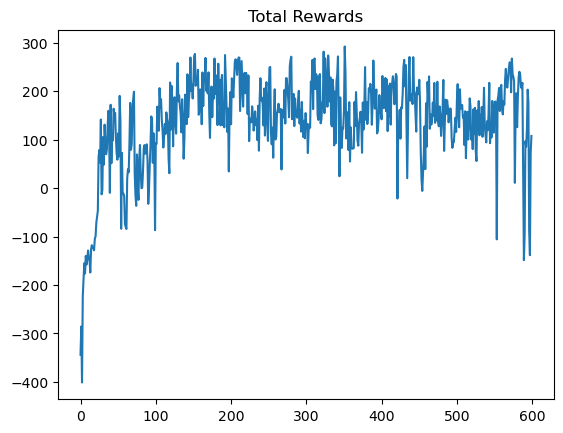

In [17]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


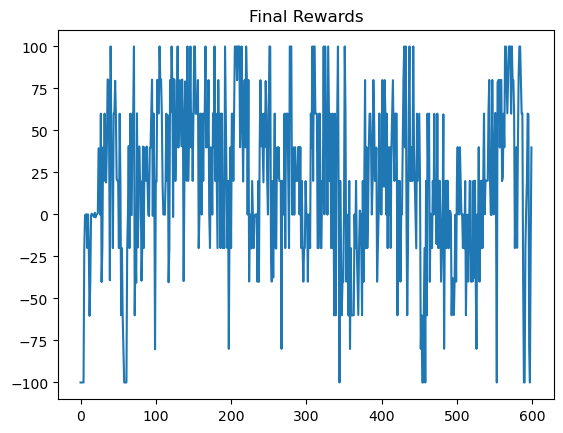

In [18]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

In [19]:
print(np.mean(test_total_reward))

93.8963037703824


Action list

In [20]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 3, 2, 2, 1, 3, 2, 2, 2, 3, 1, 2, 2, 0, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

/home/robert/miniconda3/envs/ML/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [24]:
print(best_batch)

331


Saving the result of Model Testing


In [21]:
PATH = "Action_List_test" + str(best_batch) + ".npy"# Can be modified into the name or path you want

# Server 
The code below simulate the environment on the judge server. Can be used for testing.

Your reward is : 280.03
Your reward is : 312.55
Your reward is : 262.37
Your reward is : 272.87
Your reward is : 266.92


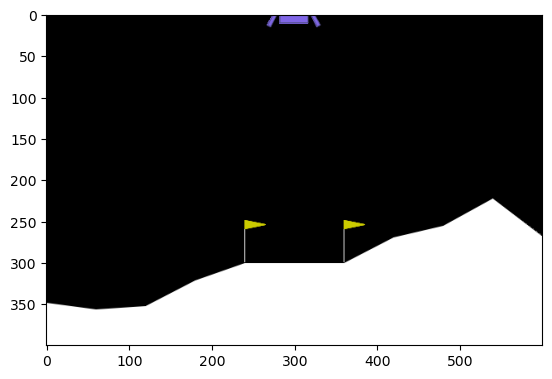

In [22]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 2023 # Do not revise this
fix(env, seed)

agent.main_q_network.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:
  
      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [23]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 278.95


## Reference

Below are some useful tips for you to get high score.

- [DQN](https://github.com/udacity/deep-reinforcement-learning)
- [DQN - pytorch](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
- [DQN](https://github.com/ranjitation/DQN-for-LunarLander)
- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
